# (08) Gabor Stats

**Motivation**: Fit log-gabor. Visualize stats. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Fig save dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'ccn_apr19')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

['thetas.pdf']

## Device

In [3]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load model

In [4]:
tr, meta = load_model(
    model_name='poisson_uniform_c(-3)_rmax(0.99)_DOVES_z-512_<lin|lin>',
    fit_name='ep3600-b1000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_04_08,15:52)',
    device=device,
    verbose=True,
)

# params: 262.7 K

In [5]:
data, loss, rates = tr.validate()
_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']

dead_thres = 0.003
dead = loss['kl_diag'] < dead_thres

print(_loss, f"\n# dead neurons: {dead.sum()}\n")

{'mse': 136.95728, 'kl': 29.922113, 'kl_diag': 0.05776923, 'tot': 166.8794}

# dead neurons: 2

## Log-Gabor fit

In [6]:
from analysis.eval import fit_loggabor
from figures.theta import plot_theta

In [7]:
results = fit_loggabor(tr, verbose=True)

100%|███████████| 512/512 [00:16<00:00, 31.74it/s]


In [8]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan

results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,507.000000,507.000000,507.000000,503.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,7.496967,7.528738,0.022050,0.275196,-0.103943,0.459654,0.389755,92.505989,0.317921
std,3.875077,4.213400,1.035318,0.136229,1.283574,0.247358,0.416870,46.962029,0.140208
min,0.316312,0.000196,-1.570794,0.087685,-4.207171,0.043200,0.054442,0.084587,0.003946
25%,4.283920,3.767123,-1.005787,0.225450,-0.856374,0.347857,0.200212,57.255117,0.226569
50%,7.577418,7.726885,-0.005946,0.255651,-0.210460,0.425285,0.306868,91.146899,0.351436
75%,10.665793,11.219438,0.964709,0.287796,0.629225,0.504310,0.484241,122.984513,0.417173
max,14.441869,15.470516,1.570796,1.704270,3.673896,4.019392,7.456292,179.948821,0.639750


## Make figs

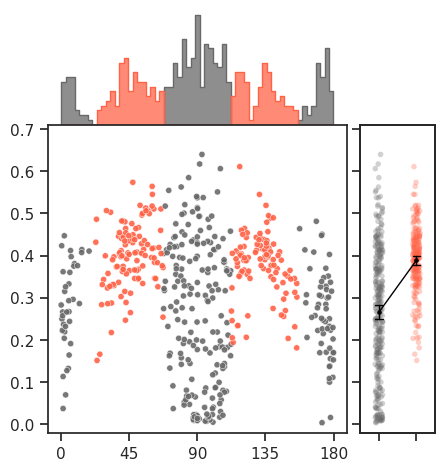

In [10]:
fig, _ = plot_theta(results)
fig.savefig(pjoin(fig_dir, 'thetas.pdf'), **kws_fig)

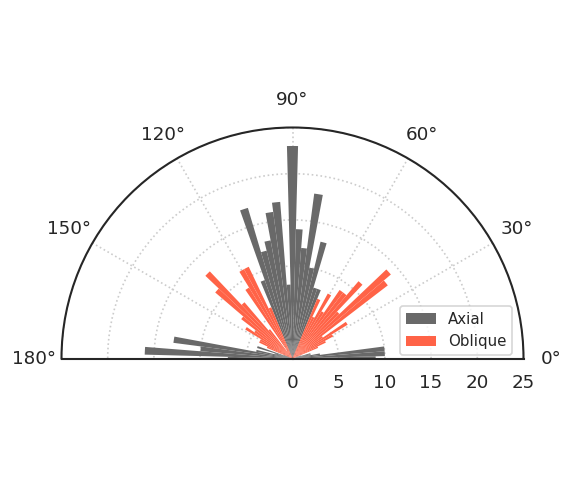

In [11]:
bin_width = 3.0
bins = np.linspace(
    start=0,
    stop=180 + bin_width,
    num=int(np.ceil(180 / bin_width)) + 2,
) - bin_width / 2
bin_mid = np.deg2rad((bins[:-1] + bins[1:]) / 2)

axial_hist, _ = np.histogram(results.loc[results['label'] == 'axial', 'theta_deg'], bins)
oblique_hist, _ = np.histogram(results.loc[results['label'] == 'oblique', 'theta_deg'], bins)

fig, ax = create_figure(1, 1, (8, 5), dpi=120, subplot_kw={'polar': True})
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_direction(1)  # Counter-clockwise
ax.set_theta_zero_location('E')  # 0 degrees to the left

ax.bar(bin_mid, axial_hist, width=np.radians(bin_width), color='dimgrey', edgecolor='none', label='Axial')
ax.bar(bin_mid, oblique_hist, width=np.radians(bin_width), color='tomato', edgecolor='none', label='Oblique', bottom=axial_hist)
ax.legend(fontsize=9)
move_legend(ax, (0.992, 0.38))
ax.set_ylim((0, 25))
plt.show()

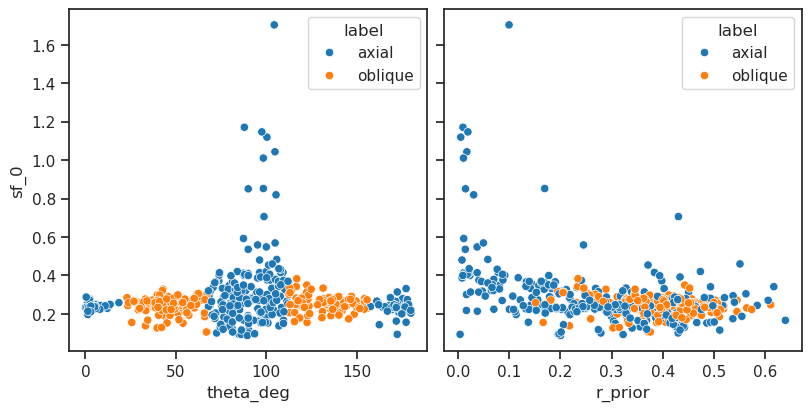

In [12]:
fig, axes = create_figure(1, 2, (8, 4), sharey='row', layout='constrained')
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', ax=axes[0])
sns.scatterplot(data=results, y='sf_0', x='r_prior', hue='label', ax=axes[1])
plt.show()

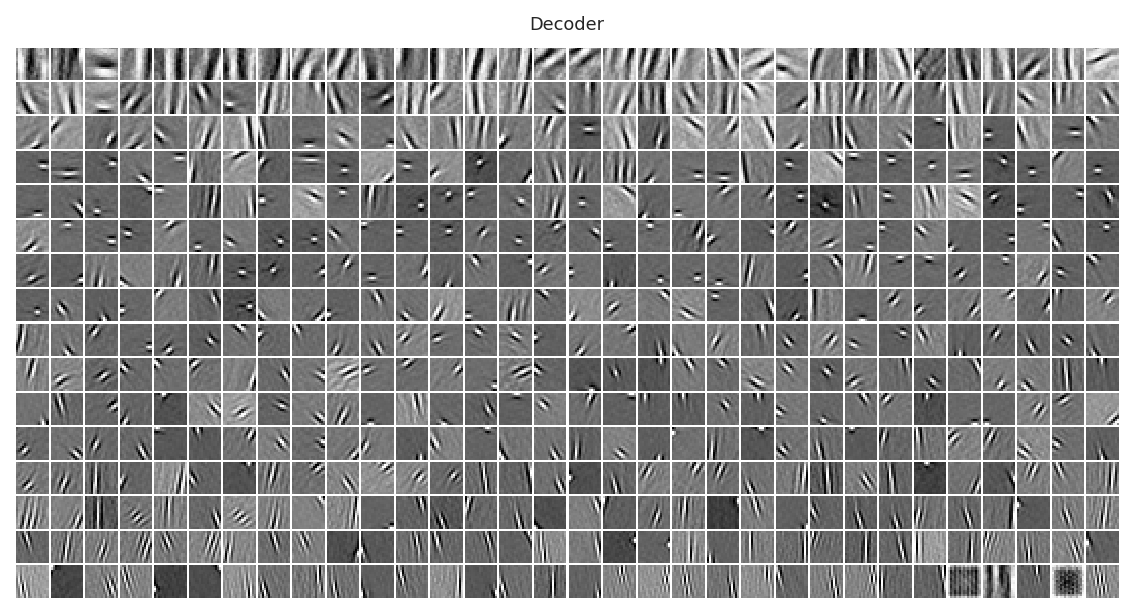

In [13]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

### High and low spatial frequencies

In [20]:
w = to_np(tr.model.fc_dec.weight.data)
w = w.T.reshape(-1, 16, 16)
w.shape

(512, 16, 16)

In [21]:
inds = np.argsort(results['sf_0'].values)

In [23]:
from figures.weight import plot_weights

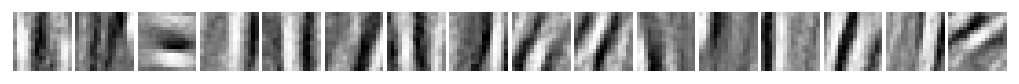

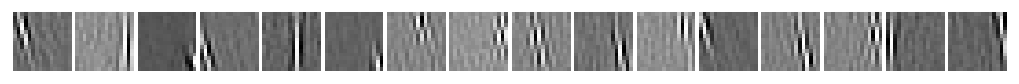

In [24]:
plot_weights(w[inds[:16]], nrows=1, dpi=130)
plt.show()

plot_weights(w[inds[-21:-5]], nrows=1, dpi=130)
plt.show()

## statistical tests

In [25]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

In [26]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')

MannwhitneyuResult(statistic=15860.0, pvalue=1.636329366359182e-21)

In [27]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='exact')

MannwhitneyuResult(statistic=15860.0, pvalue=1.0021737972712317e-22)

In [28]:
sp_stats.ks_2samp(rates_axial, rates_oblique)

KstestResult(statistic=0.46489327811404907, pvalue=9.80885507957906e-25, statistic_location=0.32834205, statistic_sign=1)

---
## Older code

In [5]:
from LogGabor import LogGaborFit

parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGaborFit(parameterfile)
lg.set_size((16, 16))

### Fit lg

In [6]:
w_dec = to_np(tr.model.fc_dec.weight.data)
w_fitted = np.zeros((w_dec.shape[1], 16, 16))
results = collections.defaultdict(list)

for i in tqdm(range(w_dec.shape[1]), ncols=50):
    w = w_dec[:, i].reshape(lg.pe.N_X, lg.pe.N_Y)
    try:
        w_fitted[i], params = lg.LogGaborFit(w)
    except ValueError:
        for k in results:
            results[k].append(np.nan)
        continue
    for k, v in params.items():
        results[k].append(v.value)

results = pd.DataFrame(results)

100%|███████████| 512/512 [00:16<00:00, 31.46it/s]


### fnialize results df

In [7]:


theta = np.rad2deg(results['theta'])
theta[theta < 0] += 180
results['theta_deg'] = theta

results['r_prior'] = to_np(tr.model.log_rates.exp().squeeze())
results['r_posterior'] = rates['r*dr'].mean(0)

thres = 22.5

cond_axial = [
    np.abs(np.rad2deg(results['theta'])) <= thres,
    np.abs(np.rad2deg(results['theta']) - 90) <= thres,
    np.abs(np.rad2deg(results['theta']) + 90) <= thres
]
cond_axial = functools.reduce(np.logical_or, cond_axial)

labels = ['oblique'] * len(results)
labels = np.array(labels)
labels[cond_axial] = 'axial'
results['label'] = labels
results.iloc[dead] = np.nan

In [140]:
vars(tr.model.cfg)

{'prior_log_dist': 'uniform',
 'prior_clamp': -3.0,
 'rmax_q': 0.99,
 'type': 'poisson',
 'enc_type': 'lin',
 'dec_type': 'lin',
 'enc_bias': False,
 'dec_bias': False,
 'dataset': 'DOVES',
 'input_sz': 16,
 'n_ch': 32,
 'n_latents': 512,
 'weight_norm': True,
 'use_bn': False,
 'use_se': True,
 'res_eps': 1.0,
 'activation_fn': 'swish',
 'base_dir': '/home/hadi/Projects/PoissonVAE',
 'results_dir': '/home/hadi/Projects/PoissonVAE/results',
 'runs_dir': '/home/hadi/Projects/PoissonVAE/runs/poisson_uniform_c(-3)_rmax(0.99)_DOVES_z-512_<lin|lin>',
 'save_dir': '/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(0.99)_DOVES_z-512_<lin|lin>',
 'data_dir': '/home/hadi/Datasets',
 'seed': 0}

In [144]:
tr.model.cfg.input_sz, tr.model.cfg.n_latents

(16, 512)

In [143]:
results

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior,r_posterior,label
0,2.661679,12.199867,-1.315022,0.332789,-0.033961,0.372982,0.230339,104.654769,0.183950,0.188754,axial
1,3.994274,9.980048,-1.364041,0.273259,-2.856274,0.314068,0.192114,101.846192,0.121568,0.124454,axial
2,11.376751,1.395601,0.892880,0.203159,1.532183,0.505535,0.391709,51.158230,0.466552,0.495021,oblique
3,1.999348,9.728077,1.570796,0.175131,1.131820,0.357692,0.280810,90.000000,0.537100,0.538690,axial
4,2.555019,10.820092,0.610732,0.237549,-0.488922,0.394305,0.548860,34.992355,0.328966,0.354256,oblique
...,...,...,...,...,...,...,...,...,...,...,...
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005728,0.005718,oblique
508,8.714361,2.156840,0.050941,0.211498,-0.369299,0.509231,0.589247,2.918715,0.232217,0.259950,axial
509,7.098429,14.234885,1.570796,0.178376,-0.210460,0.215383,0.174096,90.000000,0.336270,0.336490,axial
510,7.839106,4.142432,1.328827,0.120408,1.800478,0.282073,0.154342,76.136187,0.368756,0.372877,axial


In [12]:
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior,r_posterior
count,507.000000,507.000000,507.000000,503.000000,507.000000,507.000000,507.000000,507.000000,510.000000,510.000000
mean,7.496967,7.528738,0.022050,0.275196,-0.103943,0.459654,0.389755,92.505989,0.316947,0.335759
std,3.875077,4.213400,1.035318,0.136229,1.283574,0.247358,0.416870,46.962029,0.141264,0.148070
min,0.316312,0.000196,-1.570794,0.087685,-4.207171,0.043200,0.054442,0.084587,0.003946,0.005163
25%,4.283920,3.767123,-1.005787,0.225450,-0.856374,0.347857,0.200212,57.255117,0.224093,0.246582
50%,7.577418,7.726885,-0.005946,0.255651,-0.210460,0.425285,0.306868,91.146899,0.351263,0.376503
75%,10.665793,11.219438,0.964709,0.287796,0.629225,0.504310,0.484241,122.984513,0.417397,0.439100
max,14.441869,15.470516,1.570796,1.704270,3.673896,4.019392,7.456292,179.948821,0.639750,0.651168


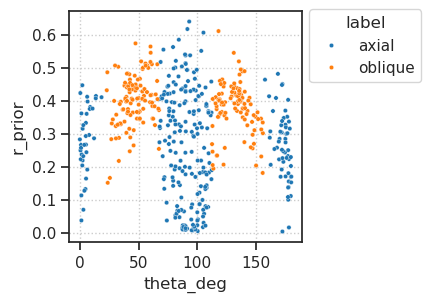

In [12]:
fig, ax = create_figure(1, 1, (3, 3))
ax = sns.scatterplot(data=results, x='theta_deg', y='r_prior', hue='label', s=10)
move_legend(ax, (1.0, 1.04))
# ax_square(ax)
# ax.set_yscale('log')
ax.grid()
plt.show()

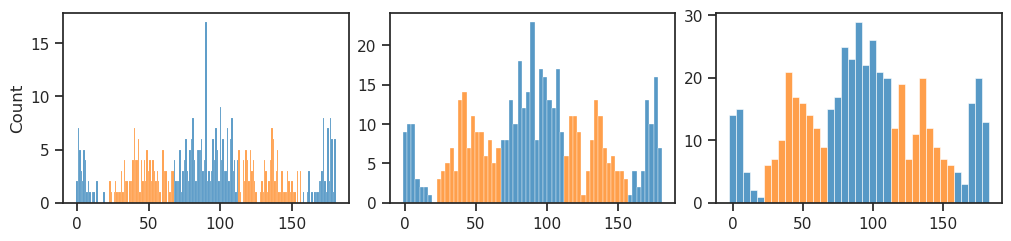

In [14]:
fig, axes = create_figure(1, 3, (10, 2.3), layout='constrained')
for i, bin_width in enumerate([1.0, 3.0, 5.0]):
    ax = axes[i]
    bins = np.linspace(
        start=0,
        stop=180 + bin_width,
        num=int(np.ceil(180 / bin_width)) + 2,
    ) - bin_width / 2

    sns.histplot(results['theta_deg'][cond_axial], bins=bins, color='C0', ax=ax)
    sns.histplot(results['theta_deg'][~cond_axial], bins=bins, color='C1', ax=ax)
    if i > 0:
        ax.set(ylabel='')
    ax.set(xlabel='')

plt.show()

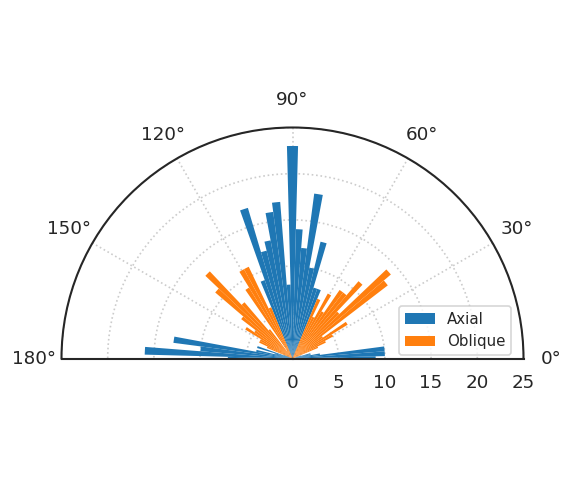

In [15]:
bin_width = 3.0
bins = np.linspace(
    start=0,
    stop=180 + bin_width,
    num=int(np.ceil(180 / bin_width)) + 2,
) - bin_width / 2
bin_mid = np.deg2rad((bins[:-1] + bins[1:]) / 2)

axial_hist, _ = np.histogram(results['theta_deg'][cond_axial], bins)
oblique_hist, _ = np.histogram(results['theta_deg'][~cond_axial], bins)

fig, ax = create_figure(1, 1, (8, 5), dpi=120, subplot_kw={'polar': True})
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_direction(1)  # Counter-clockwise
ax.set_theta_zero_location('E')  # 0 degrees to the left

ax.bar(bin_mid, axial_hist, width=np.radians(bin_width), color='C0', edgecolor='none', label='Axial')
ax.bar(bin_mid, oblique_hist, width=np.radians(bin_width), color='C1', edgecolor='none', label='Oblique', bottom=axial_hist)
ax.legend(fontsize=9)
move_legend(ax, (0.99, 0.38))
ax.set_ylim((0, 25))
plt.show()

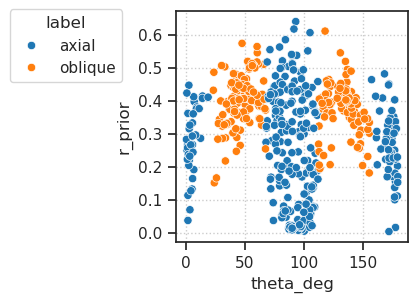

In [23]:
fig, ax = create_figure(1, 1, (3, 3))
sns.scatterplot(data=results, x='theta_deg', y='r_prior', hue='label', ax=ax)
move_legend(ax, (-0.2, 1.04))
# ax_square(ax)
# ax.set_yscale('log')
ax.grid()
plt.show()

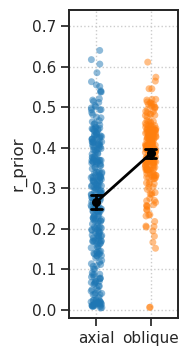

In [24]:
fig, ax = create_figure(1, 1, (1.4, 4))
axtw = ax.twiny()

palette = {'axial': 'C0', 'oblique': 'C1'}
sns.stripplot(data=results, y='r_prior', x='label', hue='label', palette=palette, alpha=0.5, ax=ax)
sns.pointplot(
    data=results, y='r_prior', x='label', color='k',
    legend=False, errorbar=('ci', 95),
    capsize=0.2,
    markers='o',
    lw=2,
    ax=axtw,
)

ax.set(xlabel='', ylim=(-0.02, 0.74))
axtw.set(xlabel='', xticks=[])
move_legend(ax)
ax.grid()
plt.show()

In [136]:
def plot_theta(df: pd.DataFrame):
    fig = plt.figure(figsize=(5, 5.5), dpi=100)
    gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1.5, 4], hspace=0.0, wspace=0.07)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax1.set(xticks=[], yticks=[])
    ax2.set(ylim=(-0.02, 0.71), xticks=[45 * i for i in range(int(np.ceil(180 / 45)) + 1)])
    ax3.set(ylim=(-0.02, 0.71), xticklabels=[], yticklabels=[])

    # histplot
    bin_width = 1.0
    bins = np.linspace(
        start=0,
        stop=180 + bin_width,
        num=int(np.ceil(180 / bin_width)) + 2,
    ) - bin_width / 2
    sns.histplot(df['theta_deg'][cond_axial], bins=bins, color='C0', ax=ax1)
    sns.histplot(df['theta_deg'][~cond_axial], bins=bins, color='C1', ax=ax1)
    remove_ticks(ax1)
    
    # scatterplot
    sns.scatterplot(data=df, x='theta_deg', y='r_prior', hue='label', alpha=0.9, ax=ax2)
    ax2.set(xlabel='', ylabel='')
    move_legend(ax2) # , (1.4, 1.3))
    # ax2.set_xlabel(r"$\theta$", fontsize=14)
    # ax2.set_ylabel('Prior firing rate', fontsize=14)
    
    # stripplot
    axtw = ax3.twiny()
    
    palette = {'axial': 'C0', 'oblique': 'C1'}
    sns.stripplot(data=df, y='r_prior', x='label', hue='label', palette=palette, size=4, alpha=0.3, ax=ax3)
    sns.pointplot(
        data=df, y='r_prior', x='label', color='k',
        legend=False, errorbar=('ci', 95),
        capsize=0.2,
        markers='o',
        lw=1,
        ax=axtw,
    )
    ax3.set(xlabel='', ylabel='')
    axtw.set(xlabel='', xticks=[])
    move_legend(ax3)

    plt.show()

In [138]:
results['label'].unique()

array(['axial', 'oblique', nan], dtype=object)

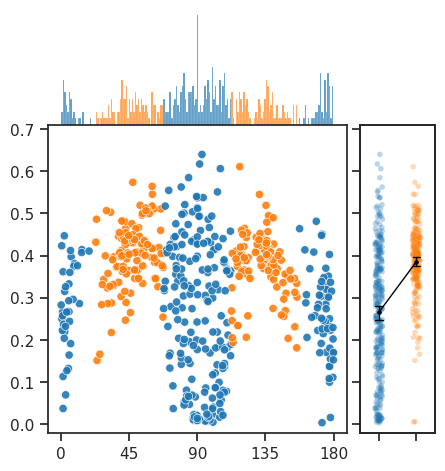

In [137]:
plot_theta(results)

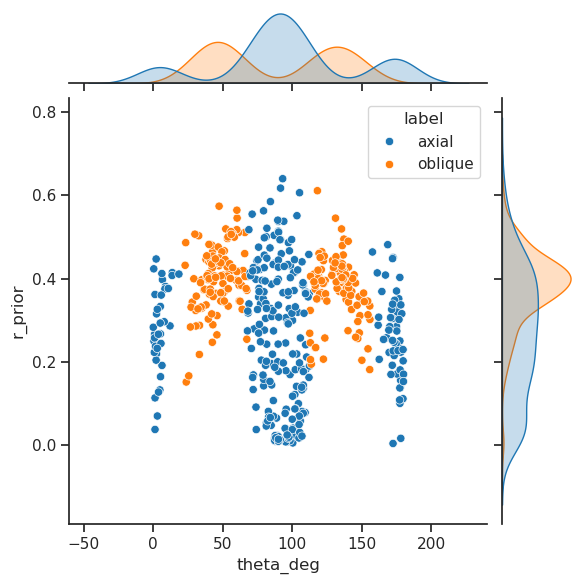

In [21]:
jg = sns.jointplot(
    data=results,
    x='theta_deg',
    y='r_prior',
    kind='scatter',
    hue='label',
)

In [22]:
sp_stats.mannwhitneyu(
    results.loc[results['label'] == 'axial', 'r_prior'],
    results.loc[results['label'] == 'oblique', 'r_prior'],
)

MannwhitneyuResult(statistic=16475.0, pvalue=1.1119128388494627e-20)

In [23]:
def bootstrap_mean_diff(data1, data2, n_bootstrap=10000):
    np.random.seed(42)  # For reproducibility
    bootstrapped_means_diff = []

    for _ in range(n_bootstrap):
        # Resample the data with replacement
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        
        # Calculate the difference in means
        diff = np.mean(sample1) - np.mean(sample2)
        bootstrapped_means_diff.append(diff)

    return np.array(bootstrapped_means_diff)

In [24]:
bootstrapped_differences = bootstrap_mean_diff(rates_oblique, rates_axial, int(1e5))

In [25]:
confidence_interval = np.percentile(bootstrapped_differences, [2.5, 97.5])
confidence_interval

array([0.09883024, 0.14041884])

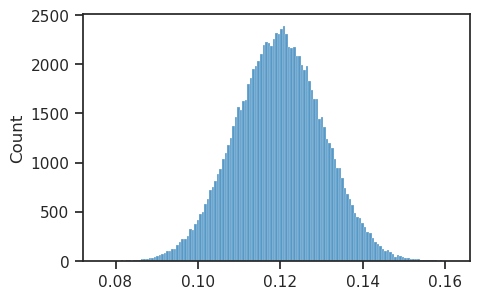

In [26]:
sns.histplot(bootstrapped_differences);

In [27]:
def permutation_test_mean_diff(data1, data2, n_permutations=10000):
    actual_diff = np.mean(data1) - np.mean(data2)

    combined = np.concatenate([data1, data2])

    count = 0
    null = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)

        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        new_diff = np.mean(new_data1) - np.mean(new_data2)
        
        null.append(new_diff)

        if abs(new_diff) >= abs(actual_diff):
            count += 1

    # Calculate the p-value
    pval = count / n_permutations

    return pval, null

In [28]:
actual_diff = np.mean(rates_oblique) - np.mean(rates_axial)
pval, null = permutation_test_mean_diff(rates_oblique, rates_axial, int(1e6))

In [29]:
pval

0.0

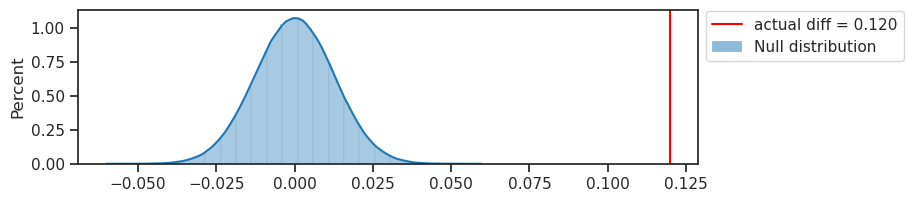

In [30]:
fig, ax = create_figure(1, 1, (8, 2))

sns.histplot(null, label='Null distribution', stat='percent', kde=True)
ax.axvline(actual_diff, color='r', label=f'actual diff = {actual_diff:0.3f}')
ax.legend()
move_legend(ax, (1.0, 1.04))
plt.show()

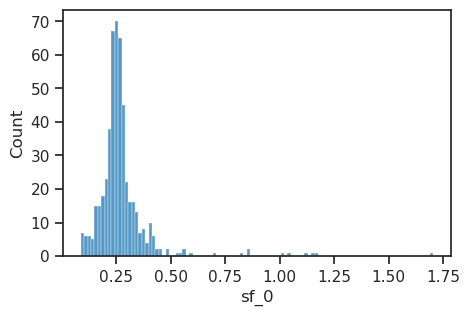

In [18]:
sns.histplot(results['sf_0']);

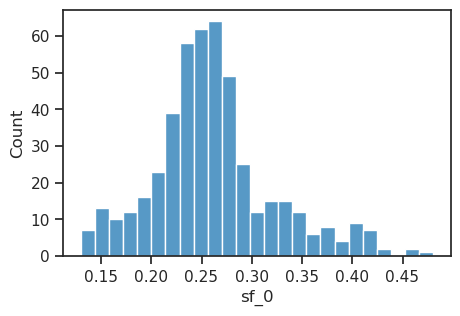

In [19]:
_df = results.loc[
    (results['sf_0'] >= np.nanquantile(results['sf_0'], 0.03)) &
    (results['sf_0'] <= np.nanquantile(results['sf_0'], 0.97))
    
]
sns.histplot(_df['sf_0']);

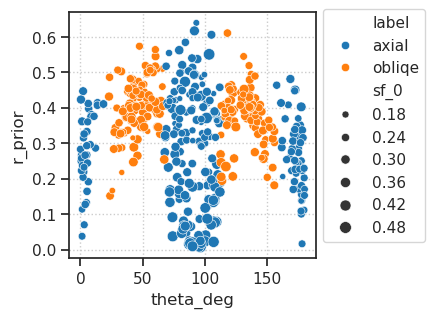

In [25]:
ax = sns.scatterplot(data=_df, x='theta_deg', y='r_prior', hue='label', size='sf_0') # size='sf_0', hue='label')
move_legend(ax, (1.0, 1.04))
ax_square(ax)
ax.grid()
plt.show()

## Find order

In [7]:
prior_rates = tr.model.log_rates.exp()
prior_rates = to_np(prior_rates.squeeze())
order = np.argsort(prior_rates)

dead = dead[order]
prior_rates = prior_rates[order]
w_dec = to_np(tr.model.fc_dec.weight.data)[:, order]

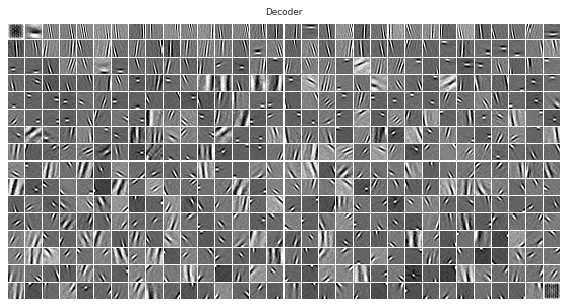

In [8]:
tr.model.show(order=order, dpi=80);

## Log-Gabor fit

In [9]:
from LogGabor import LogGaborFit

parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGaborFit(parameterfile)
lg.set_size((16, 16))

In [10]:
w_fitted = np.zeros((w_dec.shape[1], 16, 16))
results = collections.defaultdict(list)

for i in tqdm(range(len(w_fitted))):
    w = w_dec[:, i].reshape(lg.pe.N_X, lg.pe.N_Y)
    try:
        w_fitted[i], params = lg.LogGaborFit(w)
    except ValueError:
        for k in results:
            results[k].append(np.nan)
        continue
    for k, v in params.items():
        results[k].append(v.value)

results = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:15<00:00, 32.60it/s]


In [11]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan

In [12]:
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta
count,509.000000,5.090000e+02,509.000000,505.000000,509.000000,509.000000,509.000000
mean,7.490970,7.529115e+00,0.021979,0.274584,-0.104459,0.461595,0.388619
std,3.869218,4.232228e+00,1.037945,0.136356,1.281073,0.249965,0.416443
min,0.316312,8.946313e-08,-1.570794,0.061212,-4.207171,0.043200,0.054442
25%,4.285824,3.763320e+00,-1.006108,0.224948,-0.853815,0.347917,0.199437
50%,7.536244,7.726885e+00,-0.005946,0.255638,-0.210460,0.426573,0.306779
75%,10.665777,1.123755e+01,0.969348,0.287788,0.626138,0.505367,0.484223
max,14.441869,1.547052e+01,1.570796,1.704270,3.673896,4.019392,7.456292


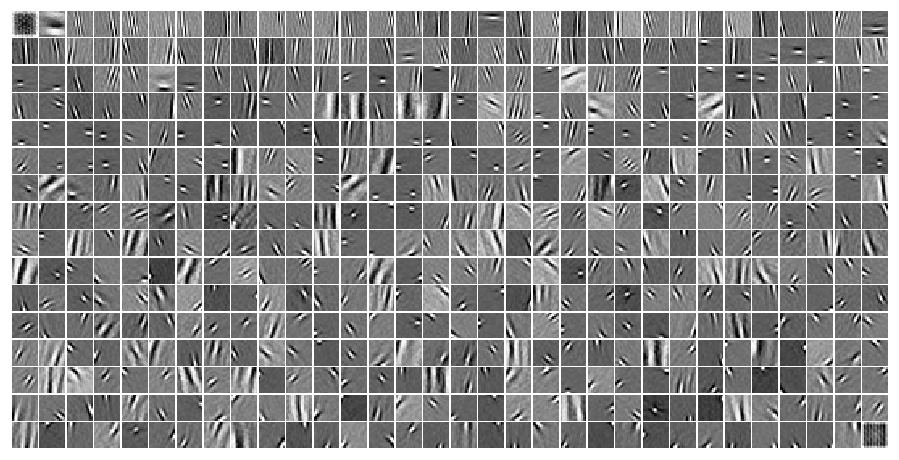

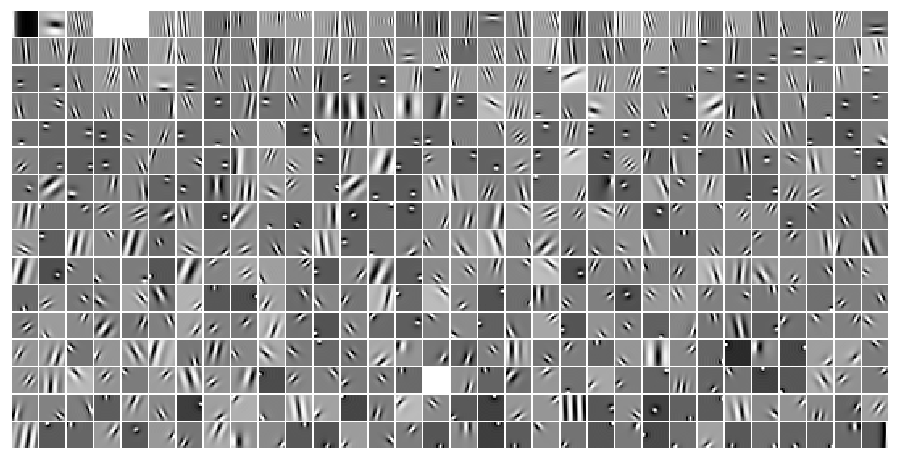

In [13]:
show_weights(w_dec.T.reshape(-1, 16, 16), dpi=120);
show_weights(w_fitted, dpi=120);

In [14]:
good = np.isfinite(results['theta'])

In [15]:
sp_stats.pearsonr(results['theta'][good], prior_rates[good])

PearsonRResult(statistic=0.07451211326770703, pvalue=0.09309906787357887)

<Axes: xlabel='theta', ylabel='Count'>

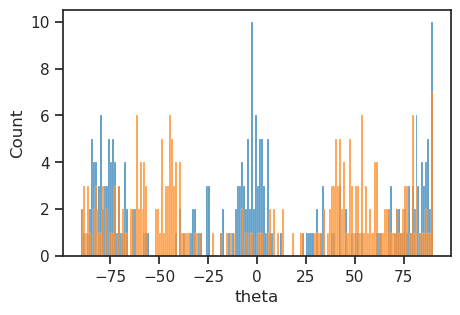

In [16]:
sns.histplot(np.rad2deg(results['theta'])[:256], bins=np.linspace(-90, 90, 181))
sns.histplot(np.rad2deg(results['theta'])[-256:], bins=np.linspace(-90, 90, 181))

In [17]:
thres = 22.5
theta = np.rad2deg(results['theta'])

cond_axial = [
    np.abs(theta) <= thres,
    np.abs(theta - 90) <= thres,
    np.abs(theta + 90) <= thres
]
cond_axial = functools.reduce(np.logical_or, cond_axial)
cond_axial.sum()

294

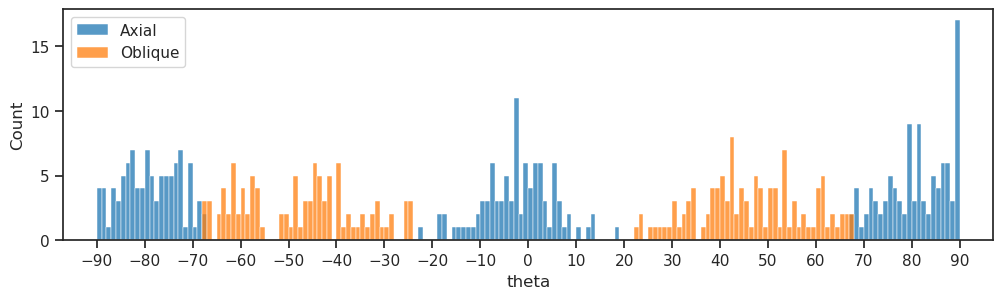

In [18]:
fig, ax = create_figure(1, 1, (12, 3))
kws = dict(bins=np.linspace(-90, 90, 181), ax=ax)
sns.histplot(theta[cond_axial], label='Axial', **kws)
sns.histplot(theta[~cond_axial], label='Oblique', **kws)
ax.set(xlim=(-97, 97))
ax.locator_params(axis='x', nbins=20)
ax.legend()
plt.show()

In [19]:
rates_axial = prior_rates[np.logical_and(cond_axial, ~dead)]
rates_oblique = prior_rates[np.logical_and(~cond_axial, ~dead)]

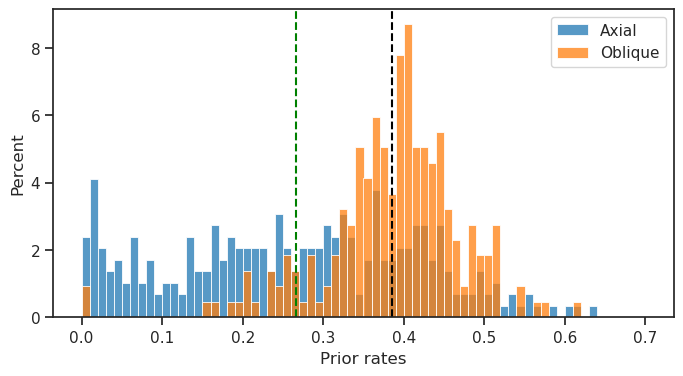

In [20]:
fig, ax = create_figure(1, 1, (8, 4))

kws = dict(bins=np.linspace(0, 0.7, 71), stat='percent', ax=ax)
sns.histplot(rates_axial, color='C0', label='Axial', **kws)
sns.histplot(rates_oblique, color='C1', label='Oblique', **kws)
ax.axvline(rates_axial.mean(), color='g', ls='--')
ax.axvline(rates_oblique.mean(), color='k', ls='--')
# ax.set_title(sp_stats.mannwhitneyu(rates_axial, rates_oriented))
ax.set_xlabel('Prior rates')
ax.legend()
plt.show()

In [21]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique)

MannwhitneyuResult(statistic=16475.0, pvalue=1.1119128388494627e-20)

In [22]:
sp_stats.ks_2samp(rates_axial, rates_oblique)

KstestResult(statistic=0.4580872188010557, pvalue=3.343932358328124e-24, statistic_location=0.32834205, statistic_sign=1)

In [23]:
def bootstrap_mean_diff(data1, data2, n_bootstrap=10000):
    np.random.seed(42)  # For reproducibility
    bootstrapped_means_diff = []

    for _ in range(n_bootstrap):
        # Resample the data with replacement
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        
        # Calculate the difference in means
        diff = np.mean(sample1) - np.mean(sample2)
        bootstrapped_means_diff.append(diff)

    return np.array(bootstrapped_means_diff)

In [24]:
bootstrapped_differences = bootstrap_mean_diff(rates_oblique, rates_axial, int(1e5))

In [25]:
confidence_interval = np.percentile(bootstrapped_differences, [2.5, 97.5])
confidence_interval

array([0.09883024, 0.14041884])

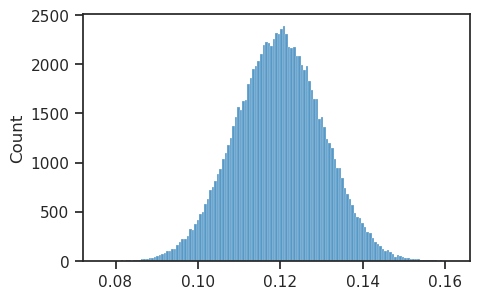

In [26]:
sns.histplot(bootstrapped_differences);

In [27]:
def permutation_test_mean_diff(data1, data2, n_permutations=10000):
    actual_diff = np.mean(data1) - np.mean(data2)

    combined = np.concatenate([data1, data2])

    count = 0
    null = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)

        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        new_diff = np.mean(new_data1) - np.mean(new_data2)
        
        null.append(new_diff)

        if abs(new_diff) >= abs(actual_diff):
            count += 1

    # Calculate the p-value
    pval = count / n_permutations

    return pval, null

In [28]:
actual_diff = np.mean(rates_oblique) - np.mean(rates_axial)
pval, null = permutation_test_mean_diff(rates_oblique, rates_axial, int(1e6))

In [29]:
pval

0.0

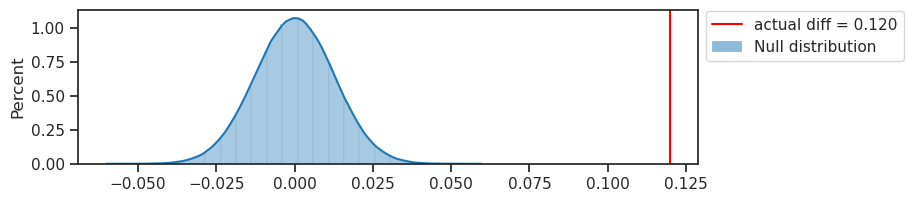

In [30]:
fig, ax = create_figure(1, 1, (8, 2))

sns.histplot(null, label='Null distribution', stat='percent', kde=True)
ax.axvline(actual_diff, color='r', label=f'actual diff = {actual_diff:0.3f}')
ax.legend()
move_legend(ax, (1.0, 1.04))
plt.show()

In [31]:
list(results)

['x_pos', 'y_pos', 'theta', 'sf_0', 'phase', 'B_sf', 'B_theta']

<Axes: xlabel='B_theta', ylabel='Count'>

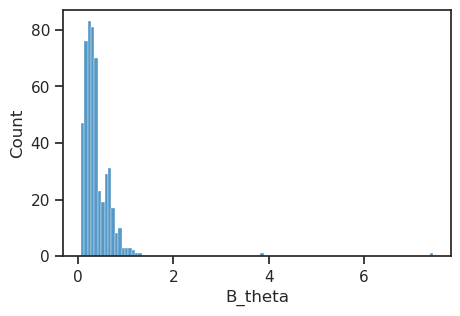

In [33]:
sns.histplot(results['B_theta'])

<Axes: xlabel='B_sf', ylabel='Count'>

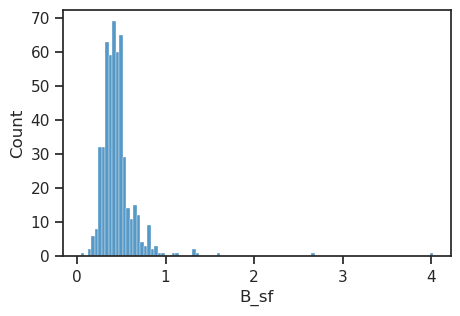

In [34]:
sns.histplot(results['B_sf'])

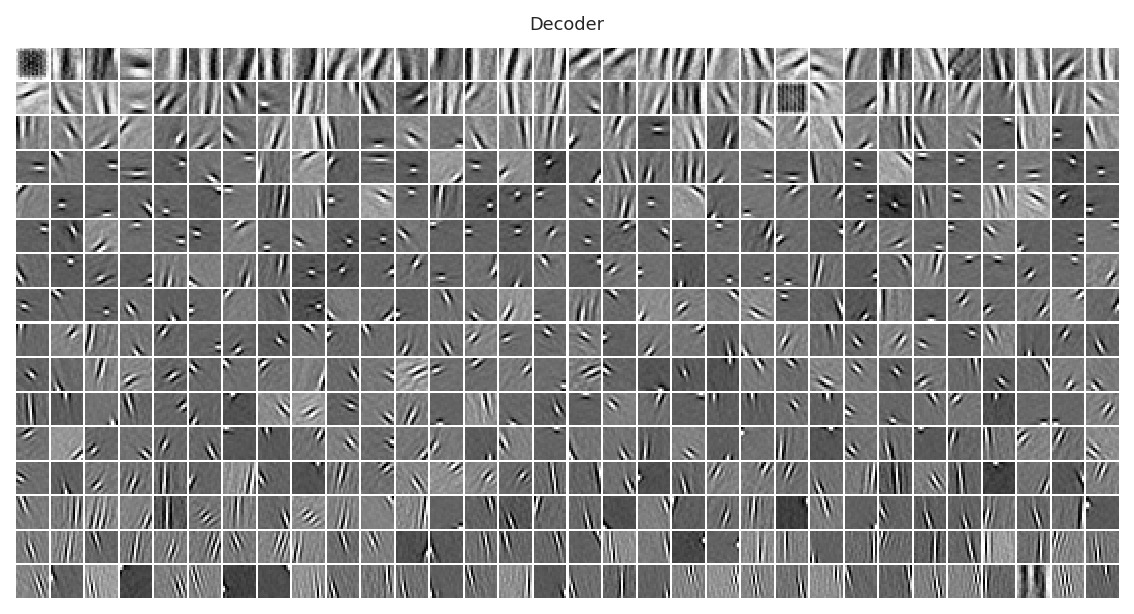

In [48]:
tr.model.show(order=order[np.argsort(results['sf_0'].values)]);

<Axes: xlabel='theta', ylabel='sf_0'>

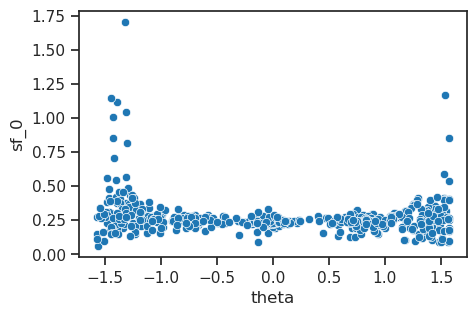

In [51]:
sns.scatterplot(data=results, x='theta', y='sf_0')

<Axes: xlabel='theta', ylabel='B_theta'>

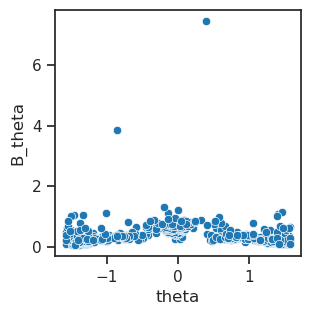

In [56]:
ax = sns.scatterplot(data=results, x='theta', y='B_theta')
ax_square(ax)

In [ ]:


# Example data
data1 = np.random.normal(0, 1, size=100)  # Group 1
data2 = np.random.normal(0.5, 1, size=120)  # Group 2

# Perform bootstrap analysis
bootstrapped_differences = bootstrap_mean_diff(data1, data2)

# Calculate the 95% confidence interval
confidence_interval = np.percentile(bootstrapped_differences, [2.5, 97.5])

print(f"Bootstrap difference in means: {np.mean(bootstrapped_differences)}")
print(f"95% confidence interval for the difference in means: {confidence_interval}")


In [196]:
posterior_rates = rates['r*dr'].mean(0)[order]

In [197]:
rates_axial = posterior_rates[np.logical_and(cond_axial, ~dead)]
rates_oblique = posterior_rates[np.logical_and(~cond_axial, ~dead)]

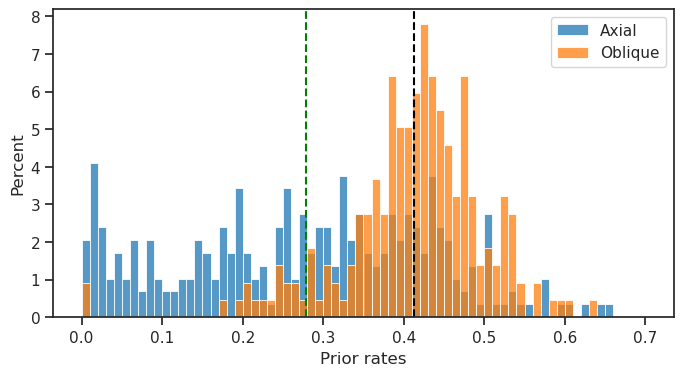

In [198]:
fig, ax = create_figure(1, 1, (8, 4))

kws = dict(bins=np.linspace(0, 0.7, 71), stat='percent', ax=ax)
sns.histplot(rates_axial, color='C0', label='Axial', **kws)
sns.histplot(rates_oblique, color='C1', label='Oblique', **kws)
ax.axvline(rates_axial.mean(), color='g', ls='--')
ax.axvline(rates_oblique.mean(), color='k', ls='--')
# ax.set_title(sp_stats.mannwhitneyu(rates_axial, rates_oriented))
ax.set_xlabel('Prior rates')
ax.legend()
plt.show()

In [199]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique)

MannwhitneyuResult(statistic=15190.0, pvalue=5.2343123185809626e-24)

In [200]:
sp_stats.ks_2samp(rates_axial, rates_oblique)

KstestResult(statistic=0.4878723136860626, pvalue=1.5725734075583065e-27, statistic_location=0.3479458, statistic_sign=1)

In [201]:
actual_diff = np.mean(rates_oblique) - np.mean(rates_axial)
pval, null = permutation_test_mean_diff(rates_oblique, rates_axial, int(1e6))

In [202]:
pval

0.0

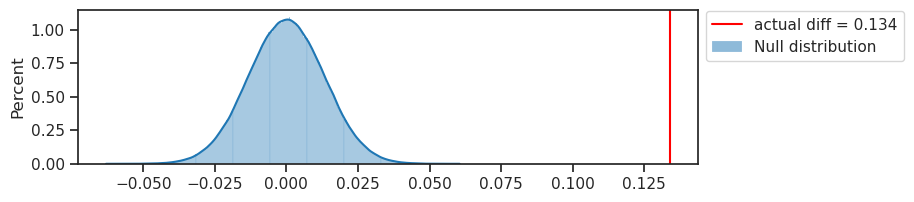

In [203]:
fig, ax = create_figure(1, 1, (8, 2))

sns.histplot(null, label='Null distribution', stat='percent', kde=True)
ax.axvline(actual_diff, color='r', label=f'actual diff = {actual_diff:0.3f}')
ax.legend()
move_legend(ax, (1.0, 1.04))
plt.show()

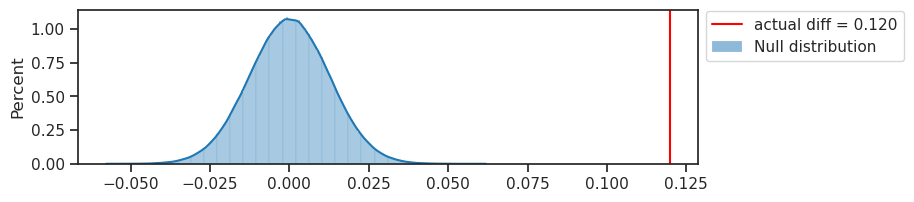

In [14]:
results

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta
0,2.661679,12.199867,-1.315022,0.332789,-0.033961,0.372982,0.230339
1,3.994274,9.980048,-1.364041,0.273259,-2.856274,0.314068,0.192114
2,11.376751,1.395601,0.892880,0.203159,1.532183,0.505535,0.391709
3,1.999348,9.728077,1.570796,0.175131,1.131820,0.357692,0.280810
4,2.555019,10.820092,0.610732,0.237549,-0.488922,0.394305,0.548860
...,...,...,...,...,...,...,...
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,8.714361,2.156840,0.050941,0.211498,-0.369299,0.509231,0.589247
509,7.098429,14.234885,1.570796,0.178376,-0.210460,0.215383,0.174096
510,7.839106,4.142432,1.328827,0.120408,1.800478,0.282073,0.154342


In [45]:
list(results)

['x_pos', 'y_pos', 'theta', 'sf_0', 'phase', 'B_sf', 'B_theta']

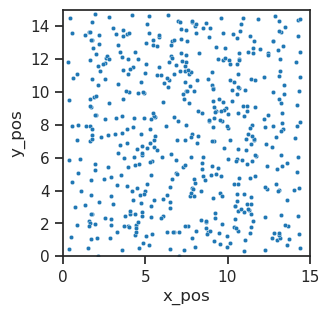

In [46]:
fig, ax = create_figure(1, 1)
sns.scatterplot(data=results, x='x_pos', y='y_pos', s=10)
ax.set(xlim=(0, 15), ylim=(0, 15))
ax_square(ax)
plt.show()

<Axes: xlabel='sf_0', ylabel='Count'>

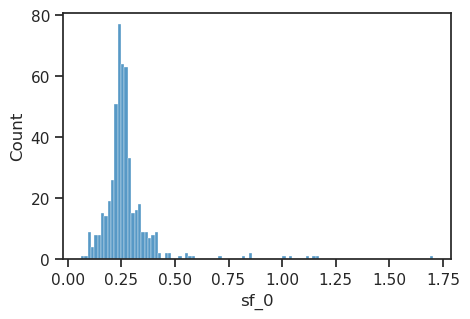

In [48]:
sns.histplot(results['sf_0'])

<Axes: ylabel='Count'>

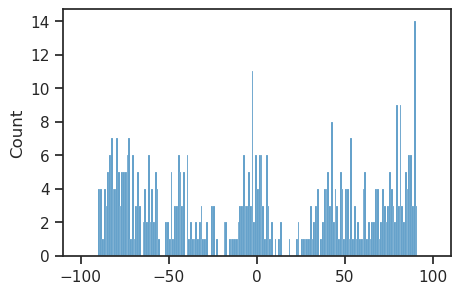

In [25]:
sns.histplot(np.rad2deg(results['theta']), bins=np.linspace(-100, 100, 201))

<Axes: ylabel='Count'>

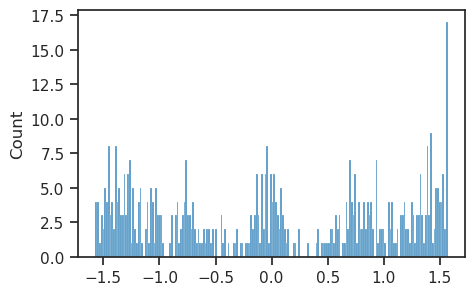

In [29]:
sns.histplot(results['theta'], bins=200)

In [11]:
w_dec = to_np(tr.model.fc_dec.weight.data)
w = w_dec[:, 68].reshape(16, 16)

In [12]:
w_fitted, params = lg.LogGaborFit(w.reshape(lg.pe.N_X, lg.pe.N_Y))

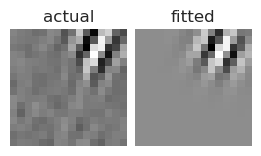

In [13]:
fig, axes = create_figure(1, 2, (2.5, 1.5), layout='constrained')
axes[0].imshow(w, cmap='Greys_r')
axes[1].imshow(w_fitted, cmap='Greys_r')

axes[0].set_title('actual')
axes[1].set_title('fitted')
remove_ticks(axes)
plt.show()

In [24]:
results = collections.defaultdict(list)
    print(k, v, v.value)

x_pos <Parameter 'x_pos', value=2.2132997194753257 +/- 0.0776, bounds=[0:16]> 2.2132997194753257

y_pos <Parameter 'y_pos', value=11.265388297047544 +/- 0.0805, bounds=[0:16]> 11.265388297047544

theta <Parameter 'theta', value=1.0795873332083374 +/- 0.00925, bounds=[-1.5707963267948966:1.5707963267948966]> 
1.0795873332083374

sf_0 <Parameter 'sf_0', value=0.3059553556156761 +/- 0.003, bounds=[0.001:inf]> 0.3059553556156761

phase <Parameter 'phase', value=-0.4221313698654539 +/- 0.157, bounds=[-inf:inf]> -0.4221313698654539

B_sf <Parameter 'B_sf', value=0.24854003367836264 +/- 0.0105, bounds=[0.001:inf]> 0.24854003367836264

B_theta <Parameter 'B_theta', value=0.24886799210535682 +/- 0.00909, bounds=[0.001:inf]> 0.24886799210535682

In [25]:
results

{'x_pos': array([2.21329972]),
 'y_pos': array([11.2653883]),
 'theta': array([1.07958733]),
 'sf_0': array([0.30595536]),
 'phase': array([-0.42213137]),
 'B_sf': array([0.24854003]),
 'B_theta': array([0.24886799])}

In [5]:
prior_rates = tr.model.log_rates.exp()
prior_rates = to_np(prior_rates.squeeze())
order = np.argsort(prior_rates)
prior_rates = prior_rates[order]

Ordered according to <span style="color:blue">prior</span> rates:

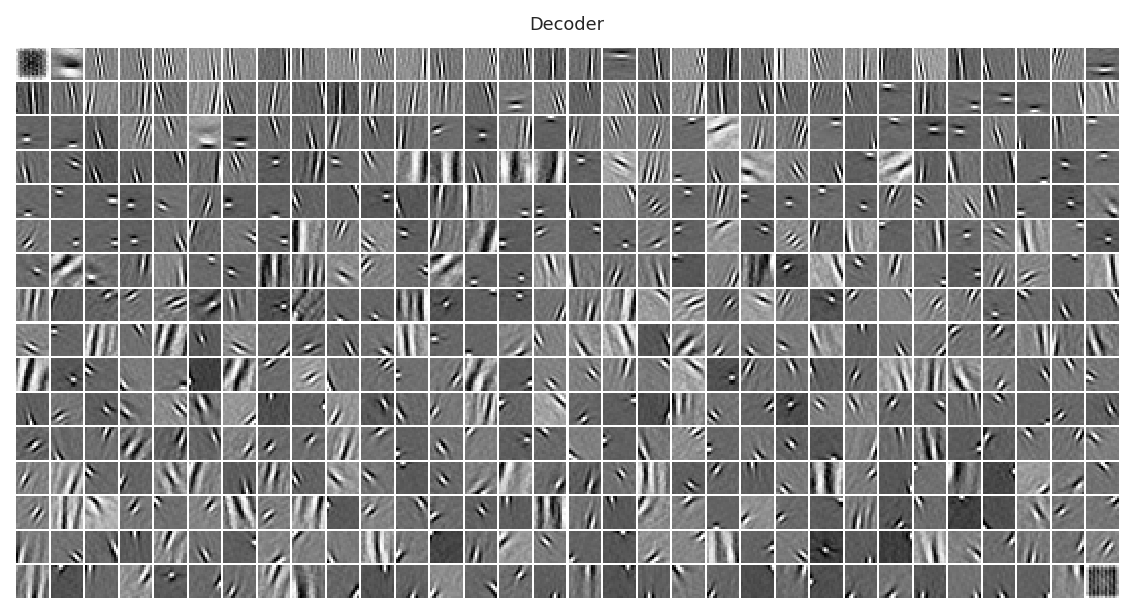

In [6]:
tr.model.show(order=order, dpi=120);

Ordered according to <span style="color:red">posterior</span> rates:

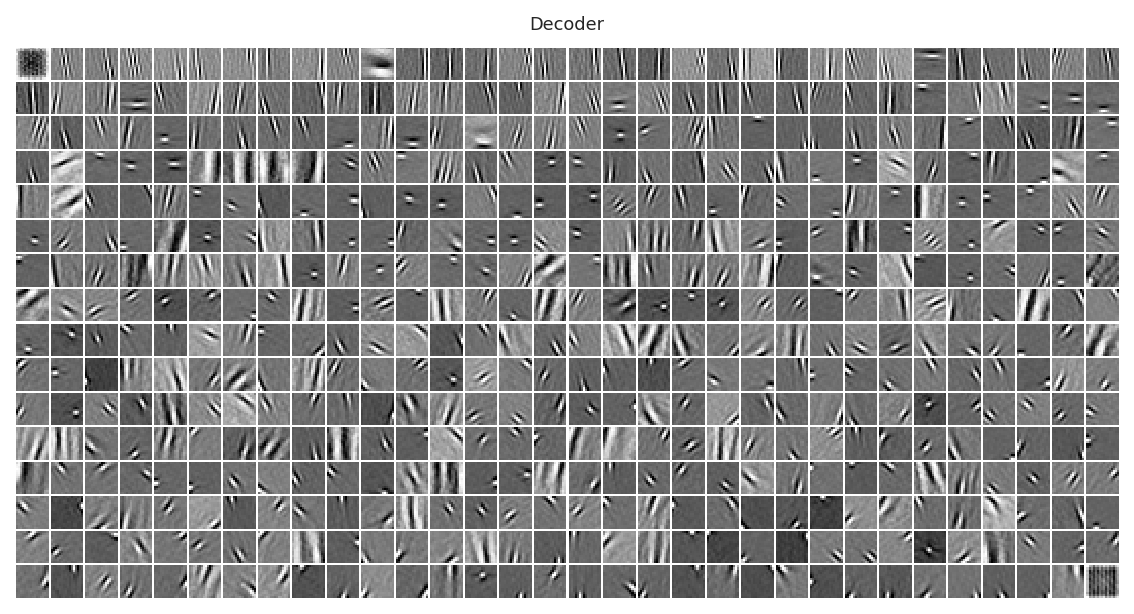

In [7]:
tr.model.show(order=np.argsort(rates['r*dr'].mean(0)), dpi=120);

## Log-gabor fit

In [40]:
from LogGabor import LogGabor, LogGaborFit
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGaborFit(parameterfile)
lg.set_size((16, 16))

In [100]:
x_pos, y_pos, theta, sf_0  = 7.6, 4.5, np.deg2rad(15), 0.3
data = lg.invert(lg.loggabor(x_pos, y_pos, sf_0=np.absolute(sf_0), B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta))
data /= np.abs(data).max()
data_noisy = data + 0.05 *np.random.normal(size=data.shape)

data_fitted, params = lg.LogGaborFit(data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y))


In [101]:
print ('params :\n', params, '\n\ntrue :\n', x_pos, y_pos, theta, sf_0)

params :

Parameters([('x_pos', <Parameter 'x_pos', value=7.61723307337675 +/- 0.0374, bounds=[0:16]>), ('y_pos', <Parameter 
'y_pos', value=4.513634918317648 +/- 0.0662, bounds=[0:16]>), ('theta', <Parameter 'theta', 
value=0.2627202327443412 +/- 0.00363, bounds=[-1.5707963267948966:1.5707963267948966]>), ('sf_0', <Parameter 
'sf_0', value=0.29825391310340466 +/- 0.00284, bounds=[0.001:inf]>), ('phase', <Parameter 'phase', 
value=0.03459756779963928 +/- 0.0658, bounds=[-inf:inf]>), ('B_sf', <Parameter 'B_sf', value=0.3720936988378031 +/-
0.0115, bounds=[0.001:inf]>), ('B_theta', <Parameter 'B_theta', value=0.16593586407543304 +/- 0.00317, 
bounds=[0.001:inf]>)])


true :
 7.6 4.5 0.2617993877991494 0.3

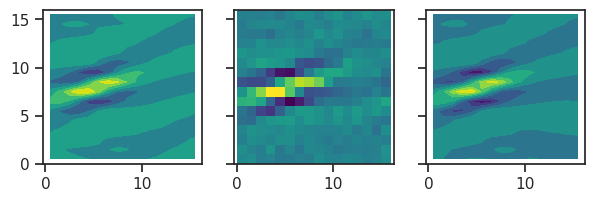

In [102]:
cmap = 'viridis'
extent = (0, lg.pe.N_X, 0, lg.pe.N_Y)

fig, axes = create_figure(1, 3, (7, 2), sharey='all')

_ = axes[0].contourf(data.reshape(lg.pe.N_X, lg.pe.N_Y), 8, extent=extent, cmap=cmap, origin='upper')
_ = axes[1].imshow(data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y), cmap=cmap, extent=extent)
_ = axes[2].contourf(data_fitted.reshape(lg.pe.N_X, lg.pe.N_Y), 8, extent=extent, cmap=cmap, origin='upper')
for ax in axes:
    ax.axis('equal')

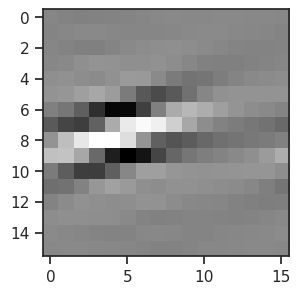

In [103]:
plt.imshow(data, cmap='Greys_r');

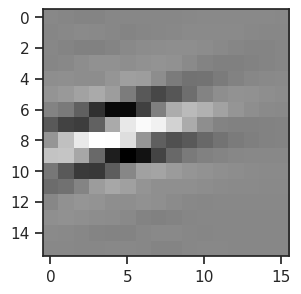

In [104]:
plt.imshow(data_fitted, cmap='Greys_r');